In [1]:
# Importando bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
import datetime as dt

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Abrindo arquivo e salvando informações dentro da variável "df". Organizando os dados pela coluna "Index" em ordem crescente.
df = pd.read_excel('data.xlsx').sort_values('Index', ascending=True)
df_ = df.copy()
# Exibe as 5 primeiras linhas do dataframe
df.head()

,Index,Year,Quarter,Week,Sunday,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Total
19,1,2021,Q3,38,NaN,564.0,542.0,462.0,398,410.0,NaN,2376
18,2,2021,Q4,39,NaN,551.0,622.0,459.0,704,568.0,NaN,2904
17,3,2021,Q4,40,NaN,551.0,443.0,375.0,452,407.0,NaN,2228
16,4,2021,Q4,41,NaN,550.0,557.0,461.0,400,455.0,NaN,2423
15,5,2021,Q4,42,NaN,524.0,432.0,408.0,393,309.0,NaN,2066


In [3]:
# Tamanho do dataframe (linhas, colunas)
df.shape

(20, 12)

In [4]:
# Avaliando o tipo do dados
dados_tipos = df.dtypes
dados_tipos

Index          int64
Year           int64
Quarter       object
Week           int64
Sunday       float64
Monday       float64
Tuesday      float64
Wednesday    float64
Thursday       int64
Friday       float64
Saturday     float64
Total          int64
dtype: object

In [5]:
# Verificando a quantidade de dados nulos por coluna
df.isnull().sum()

Index         0
Year          0
Quarter       0
Week          0
Sunday       20
Monday        2
Tuesday       1
Wednesday     1
Thursday      0
Friday        2
Saturday     20
Total         0
dtype: int64

In [6]:
# Porcentagem de dados nulos por coluna
dados_nulos = df.isnull().sum()/df.shape[0] * 100
dados_nulos

Index          0.0
Year           0.0
Quarter        0.0
Week           0.0
Sunday       100.0
Monday        10.0
Tuesday        5.0
Wednesday      5.0
Thursday       0.0
Friday        10.0
Saturday     100.0
Total          0.0
dtype: float64

__Importante:__

Aqui iremos inserir o valor "-1" nas células que estiverem vazias (Not a Number) para um posterior tratamento. Mais a frente, todas as células que apresentarem valor "-1" irá "herdar" o valor do dia anterior.

Por exemplo: Saturday, na semana 38 (linha 1), apresenta o valor -1. Após o tratamento, esse valor será substituído pelo valor 410 (valor do dia anterior, Friday). O mesmo será feito para as outras células. Isso é importante para não termos "vazios". É como se o valor ficasse congelado nos finais de semana. Não sei se isso faz sentido para você, mas para o modelo é importante.

In [7]:
# Realizando o tratamento dos dados faltantes.
for item in df.columns:
    if (dados_tipos[item] != 'O'):
        df_[item].fillna(-1, inplace=True)

In [8]:
# Planilha com os dados tratados
df_.head()

,Index,Year,Quarter,Week,Sunday,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Total
19,1,2021,Q3,38,-1.0,564.0,542.0,462.0,398,410.0,-1.0,2376
18,2,2021,Q4,39,-1.0,551.0,622.0,459.0,704,568.0,-1.0,2904
17,3,2021,Q4,40,-1.0,551.0,443.0,375.0,452,407.0,-1.0,2228
16,4,2021,Q4,41,-1.0,550.0,557.0,461.0,400,455.0,-1.0,2423
15,5,2021,Q4,42,-1.0,524.0,432.0,408.0,393,309.0,-1.0,2066


Uma outra opção é remover as linhas faltantes, mas aí precisaremos criar um dataframe para cada dia da semana. Se esse for o caso, me avise que faço a alteração. Para a previsão, o preenchimento com a média ou mediana fará mais sentido quando tiver mais dados.

In [9]:
# Criando uma lista com o nome das colunas somente com os dias da semana.
dias_semana = df.columns[4:11].tolist()

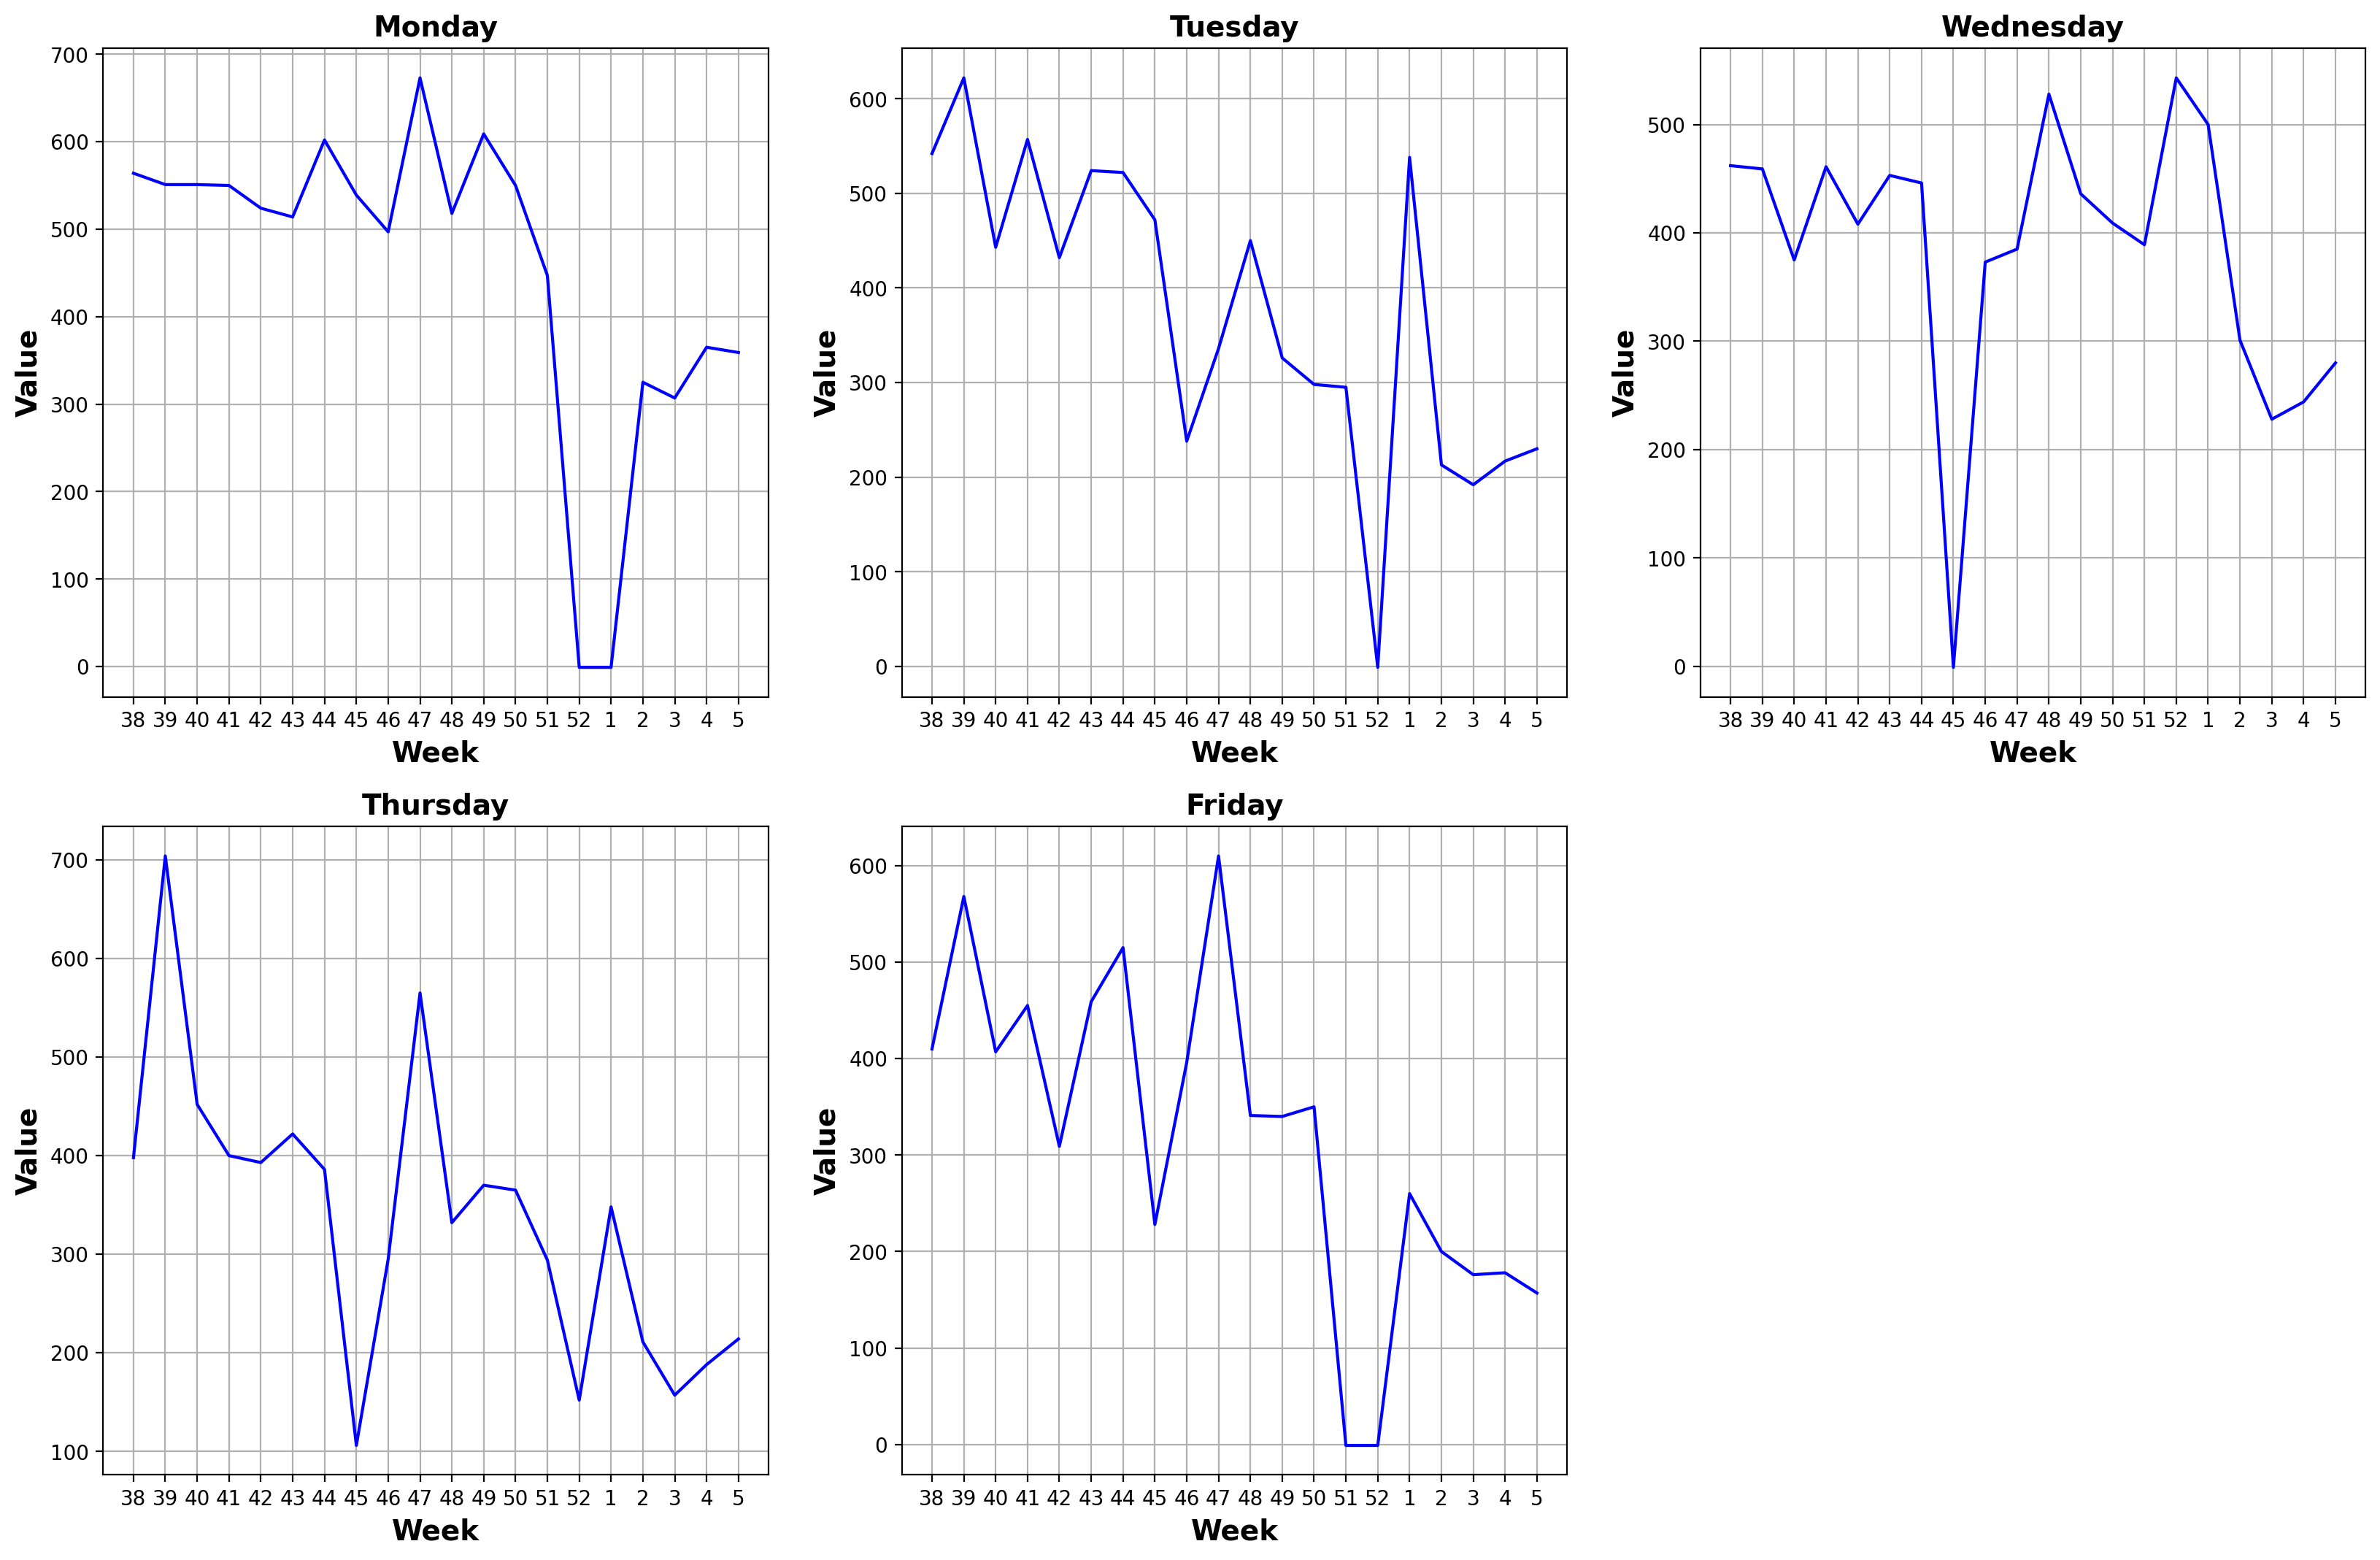

In [10]:
# Avaliando por meio de gráficos os dados pós processamento.
plt.rcParams.update({'figure.dpi':200})
# Criando figura para todas as colunas que não apresentaram 20% de dados nulos
plt.figure(figsize=[20,20])

i = 1
for item in dias_semana:
    if (dados_nulos[item] < 20):
        plt.subplot(3,3,i)
        plt.title(item, fontsize = 14, fontweight = 'bold')
        plt.plot(df_.Index.values, df_[item], c='blue')
        plt.xticks(df_.Index.values,df_.Week.values)
        plt.xlabel('Week', fontsize = 14, fontweight='bold')
        plt.ylabel('Value', fontsize = 14, fontweight='bold')
        plt.grid()
        i += 1

plt.show()

In [11]:
# Função para criar df separados por dia da semana
import datetime as dt

def criar_df(dataframe):
    
    dict = {'Monday':'1', 'Tuesday':'2', 'Wednesday':'3', 'Thursday':'4', 'Friday':'5', 'Saturday':'6', 'Sunday':'0'}
    
    lista_dias = []
    lista_valores = []
    i = 0
    
    for item1, item2 in zip(dataframe.Year.values, dataframe.Week.values):
        
        for item in dict.keys():
            
            # Convertendo datas
            d = str(item1) + '-' + str(item2)
            dia = dt.datetime.strptime(d + '-' + dict[item], "%Y-%W-%w")
            
            # Adicionando datas
            lista_dias.append(dia)
            
            # Adicionando valores
            
            if (dataframe[item].iloc[i] == -1):
                lista_valores.append(lista_valores[i-1])
            else:
                lista_valores.append(dataframe[item].iloc[i])
            
        i += 1
    
    # Criando dataframe
    dataframe_novo = pd.DataFrame(np.c_[lista_dias, lista_valores], columns = ['Date', 'Value'])
    dataframe_novo.set_index('Date', inplace=True)
    dataframe_novo['Value'] = dataframe_novo['Value'].astype(float)
    
    return dataframe_novo

In [12]:
# Novo dataframe com os dados organizados.
dfn = criar_df(df_)

# Exibindo apenas as 7 primeiras linhas
dfn.head(7)

,Value
Date,
2021-09-20,564.0
2021-09-21,542.0
2021-09-22,462.0
2021-09-23,398.0
2021-09-24,410.0
2021-09-25,410.0
2021-09-26,410.0


In [13]:
# Verificando se há dados nulos
dfn.isnull().sum()

Value    0
dtype: int64

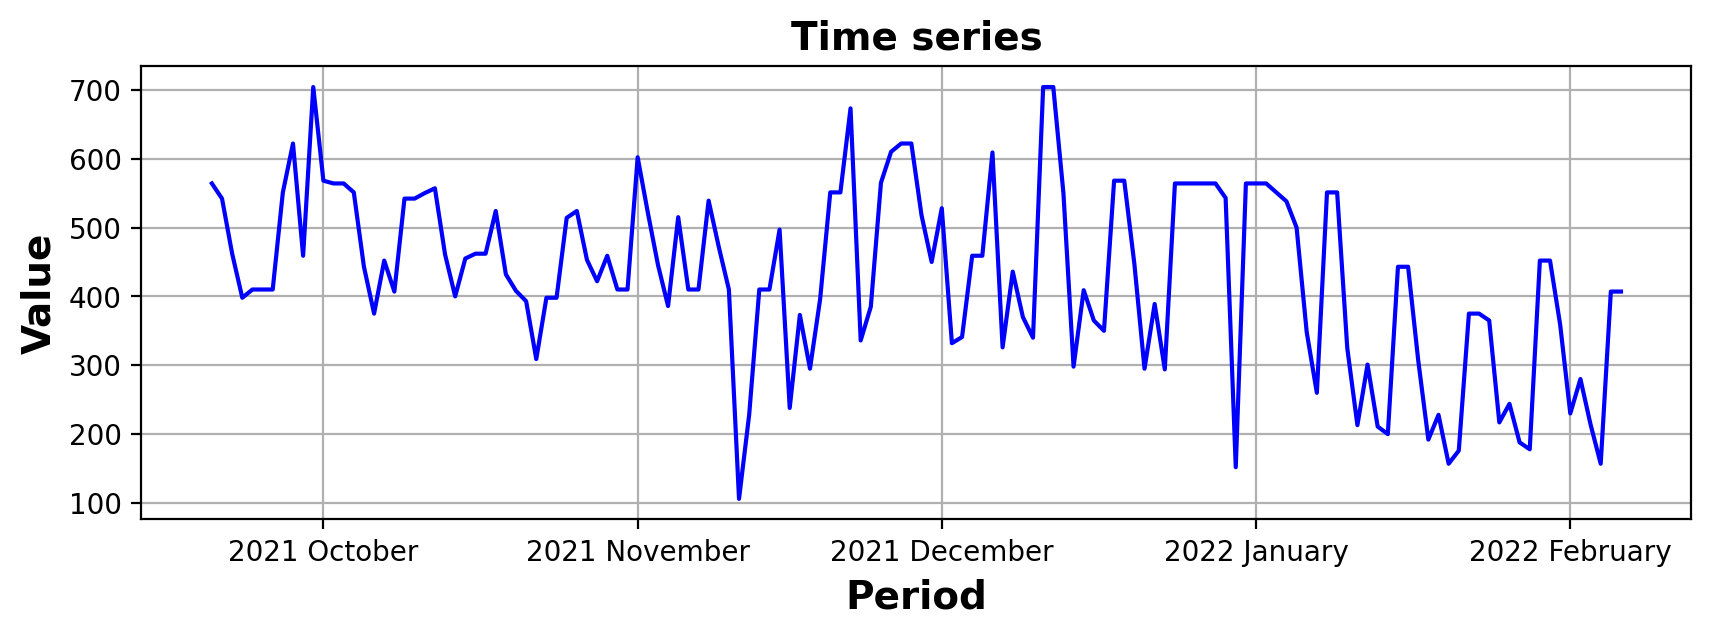

In [14]:
# Criando um gráfico para avaliar como os dados se comportam.
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':200})
fig, ax = plt.subplots(figsize=[10,3])

plt.title('Time series', fontsize = 14, fontweight = 'bold')
plt.plot(dfn.index, dfn['Value'], c='blue')
monthyearFmt = mdates.DateFormatter('%Y %B')
ax.xaxis.set_major_formatter(monthyearFmt)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
#plt.xticks(rotation=90) # Remover # da frente da linha para girar os rótulos em 90°
plt.xlabel('Period', fontsize = 14, fontweight='bold')
plt.ylabel('Value', fontsize = 14, fontweight='bold')
plt.grid()
plt.show()

#### Verificando se a série é estacionária.

Augmented Dickey Fuller test (ADF Test) é um teste estatístico que verifica se data série temporal é estacionária ou não.

In [15]:
# ADF Test
result = adfuller(dfn.Value, autolag='BIC')
print(f'ADF Statistic: {result[0]}')
print(f'n_lags: {result[2]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')  

ADF Statistic: -1.6723814135164519
n_lags: 7
p-value: 0.4453956206028076
Critial Values:
   1%, -3.4808880719210005
Critial Values:
   5%, -2.8836966192225284
Critial Values:
   10%, -2.5785857598714417


In [16]:
# ADF Test
result = adfuller(dfn.Value, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'n_lags: {result[2]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')  

ADF Statistic: -2.229122564476598
n_lags: 9
p-value: 0.19584591293748238
Critial Values:
   1%, -3.4816817173418295
Critial Values:
   5%, -2.8840418343195267
Critial Values:
   10%, -2.578770059171598


Como o valor de p obtido é maior que que àquele para um nível de significância de 0.05 ($\alpha$ = 5%) e o valor de ADF é maior que qualquer nível de significância apresentado, não é possível rejeitar a hipótese de nulidade, ou seja, a série temporal é não estacionária.

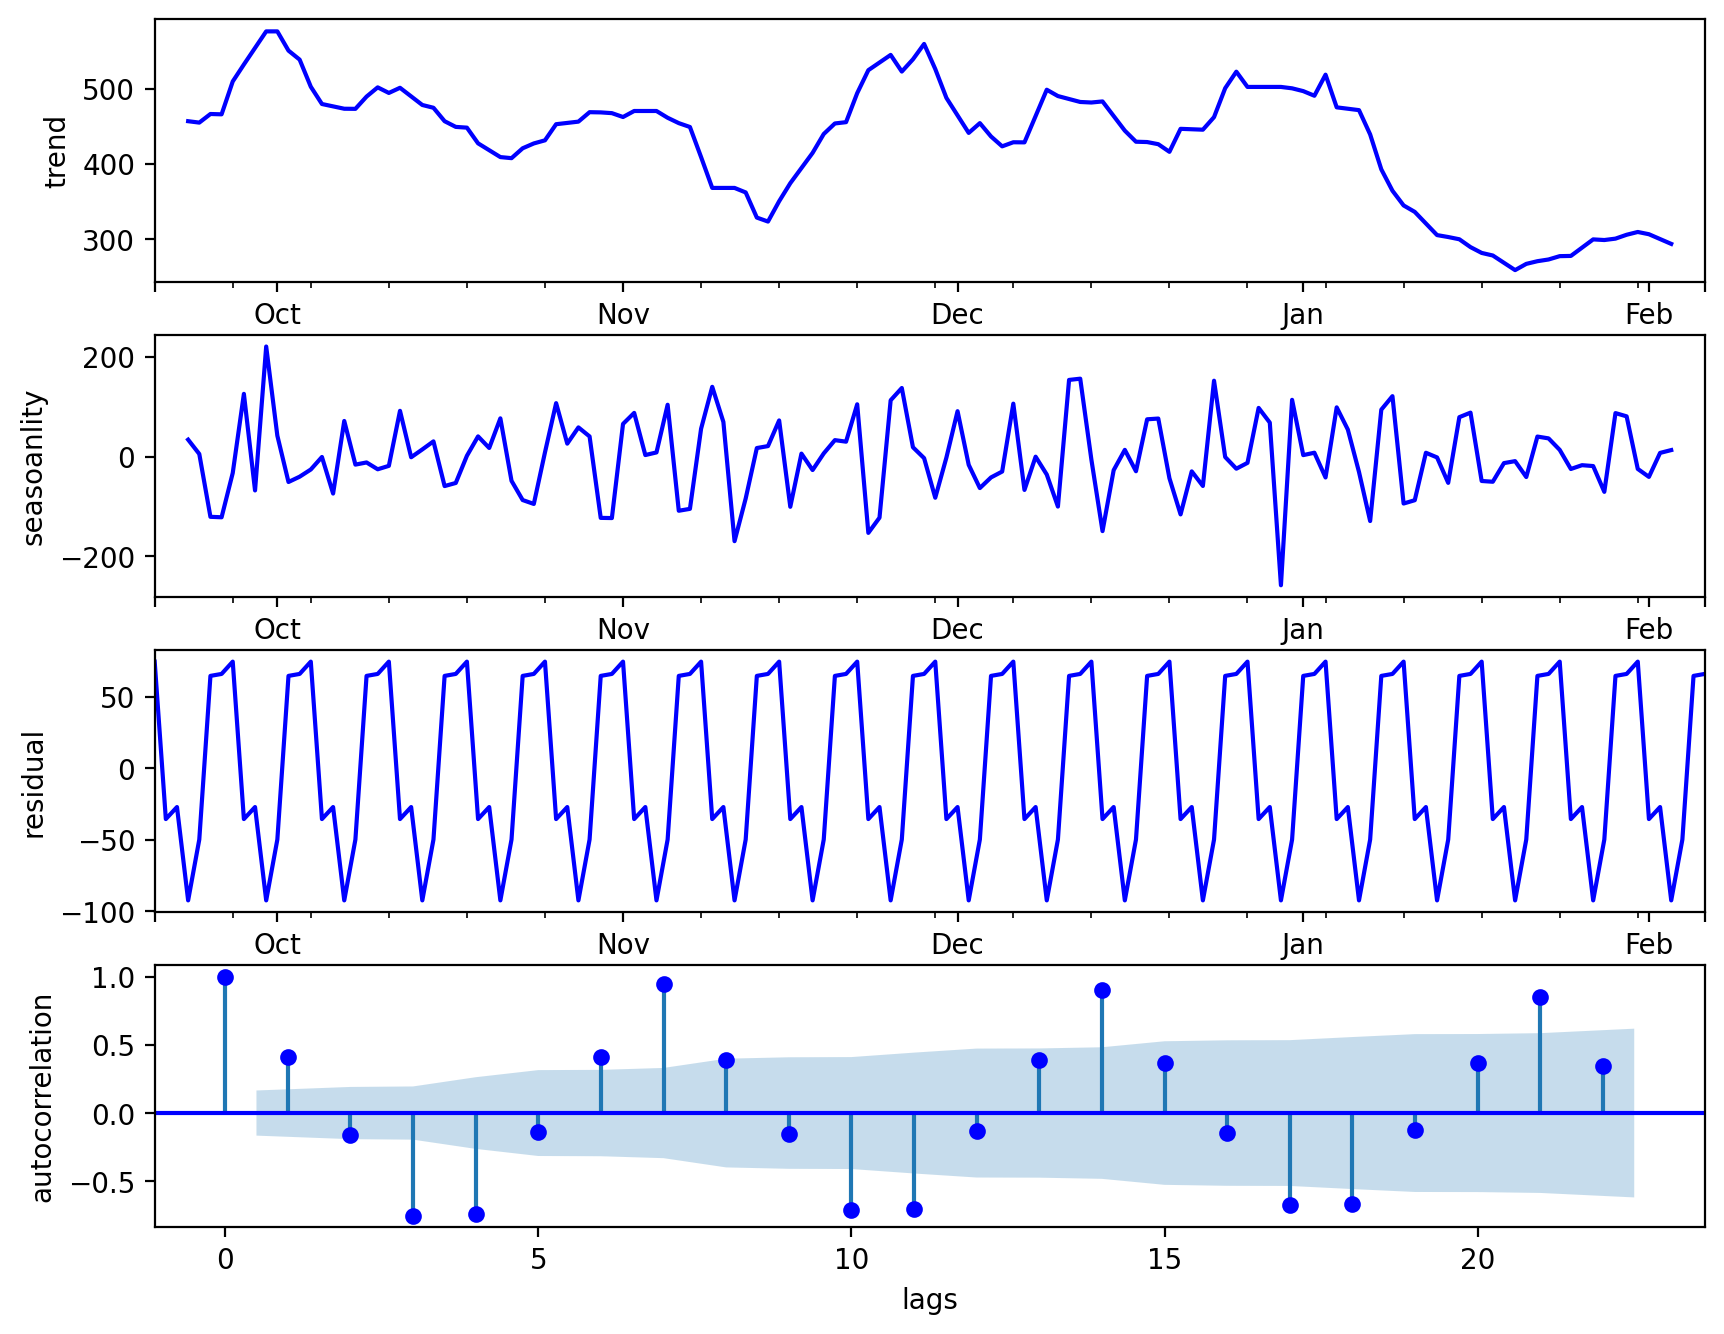

In [17]:
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':200})
res = seasonal_decompose(dfn.Value, model = 'additive')

fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize=(10,8))
res.trend.plot(ax=ax1, xlabel='', ylabel = 'trend', color='blue')
res.resid.plot(ax=ax2, xlabel='', ylabel = 'seasoanlity', color='blue')
res.seasonal.plot(ax=ax3, xlabel='', ylabel = 'residual', color='blue')
plot_acf(res.seasonal, ax=ax4, title='', color='blue')
ax4.set_xlabel('lags'); ax4.set_ylabel('autocorrelation')
plt.show()

Vemos que há alta autocorrelação nos lags 1, 7, 14, 21... indicando que há sazonalidade. Sendo assim, iremos realizar a diferenciação dos dados para obter uma série estacionária, se possível.

Uma outra forma de verificar se a série temporal é estacionária, ou não, é usando o teste KPSS (Kwiatokowski-Phillips-Schmidt-Shin test)

In [18]:
def kpss_test(series, **kw):    
    statistic, p_value, n_lags, critical_values = kpss(series, **kw)
    # Format Output
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')
    print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary')

kpss_test(dfn.Value)

KPSS Statistic: 0.5010911631468402
p-value: 0.04142090920116212
num lags: 14
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is not stationary


Nesse caso, como o valor de p é menor o nível de significância de 5% (0,05), a série não é estacionária.}

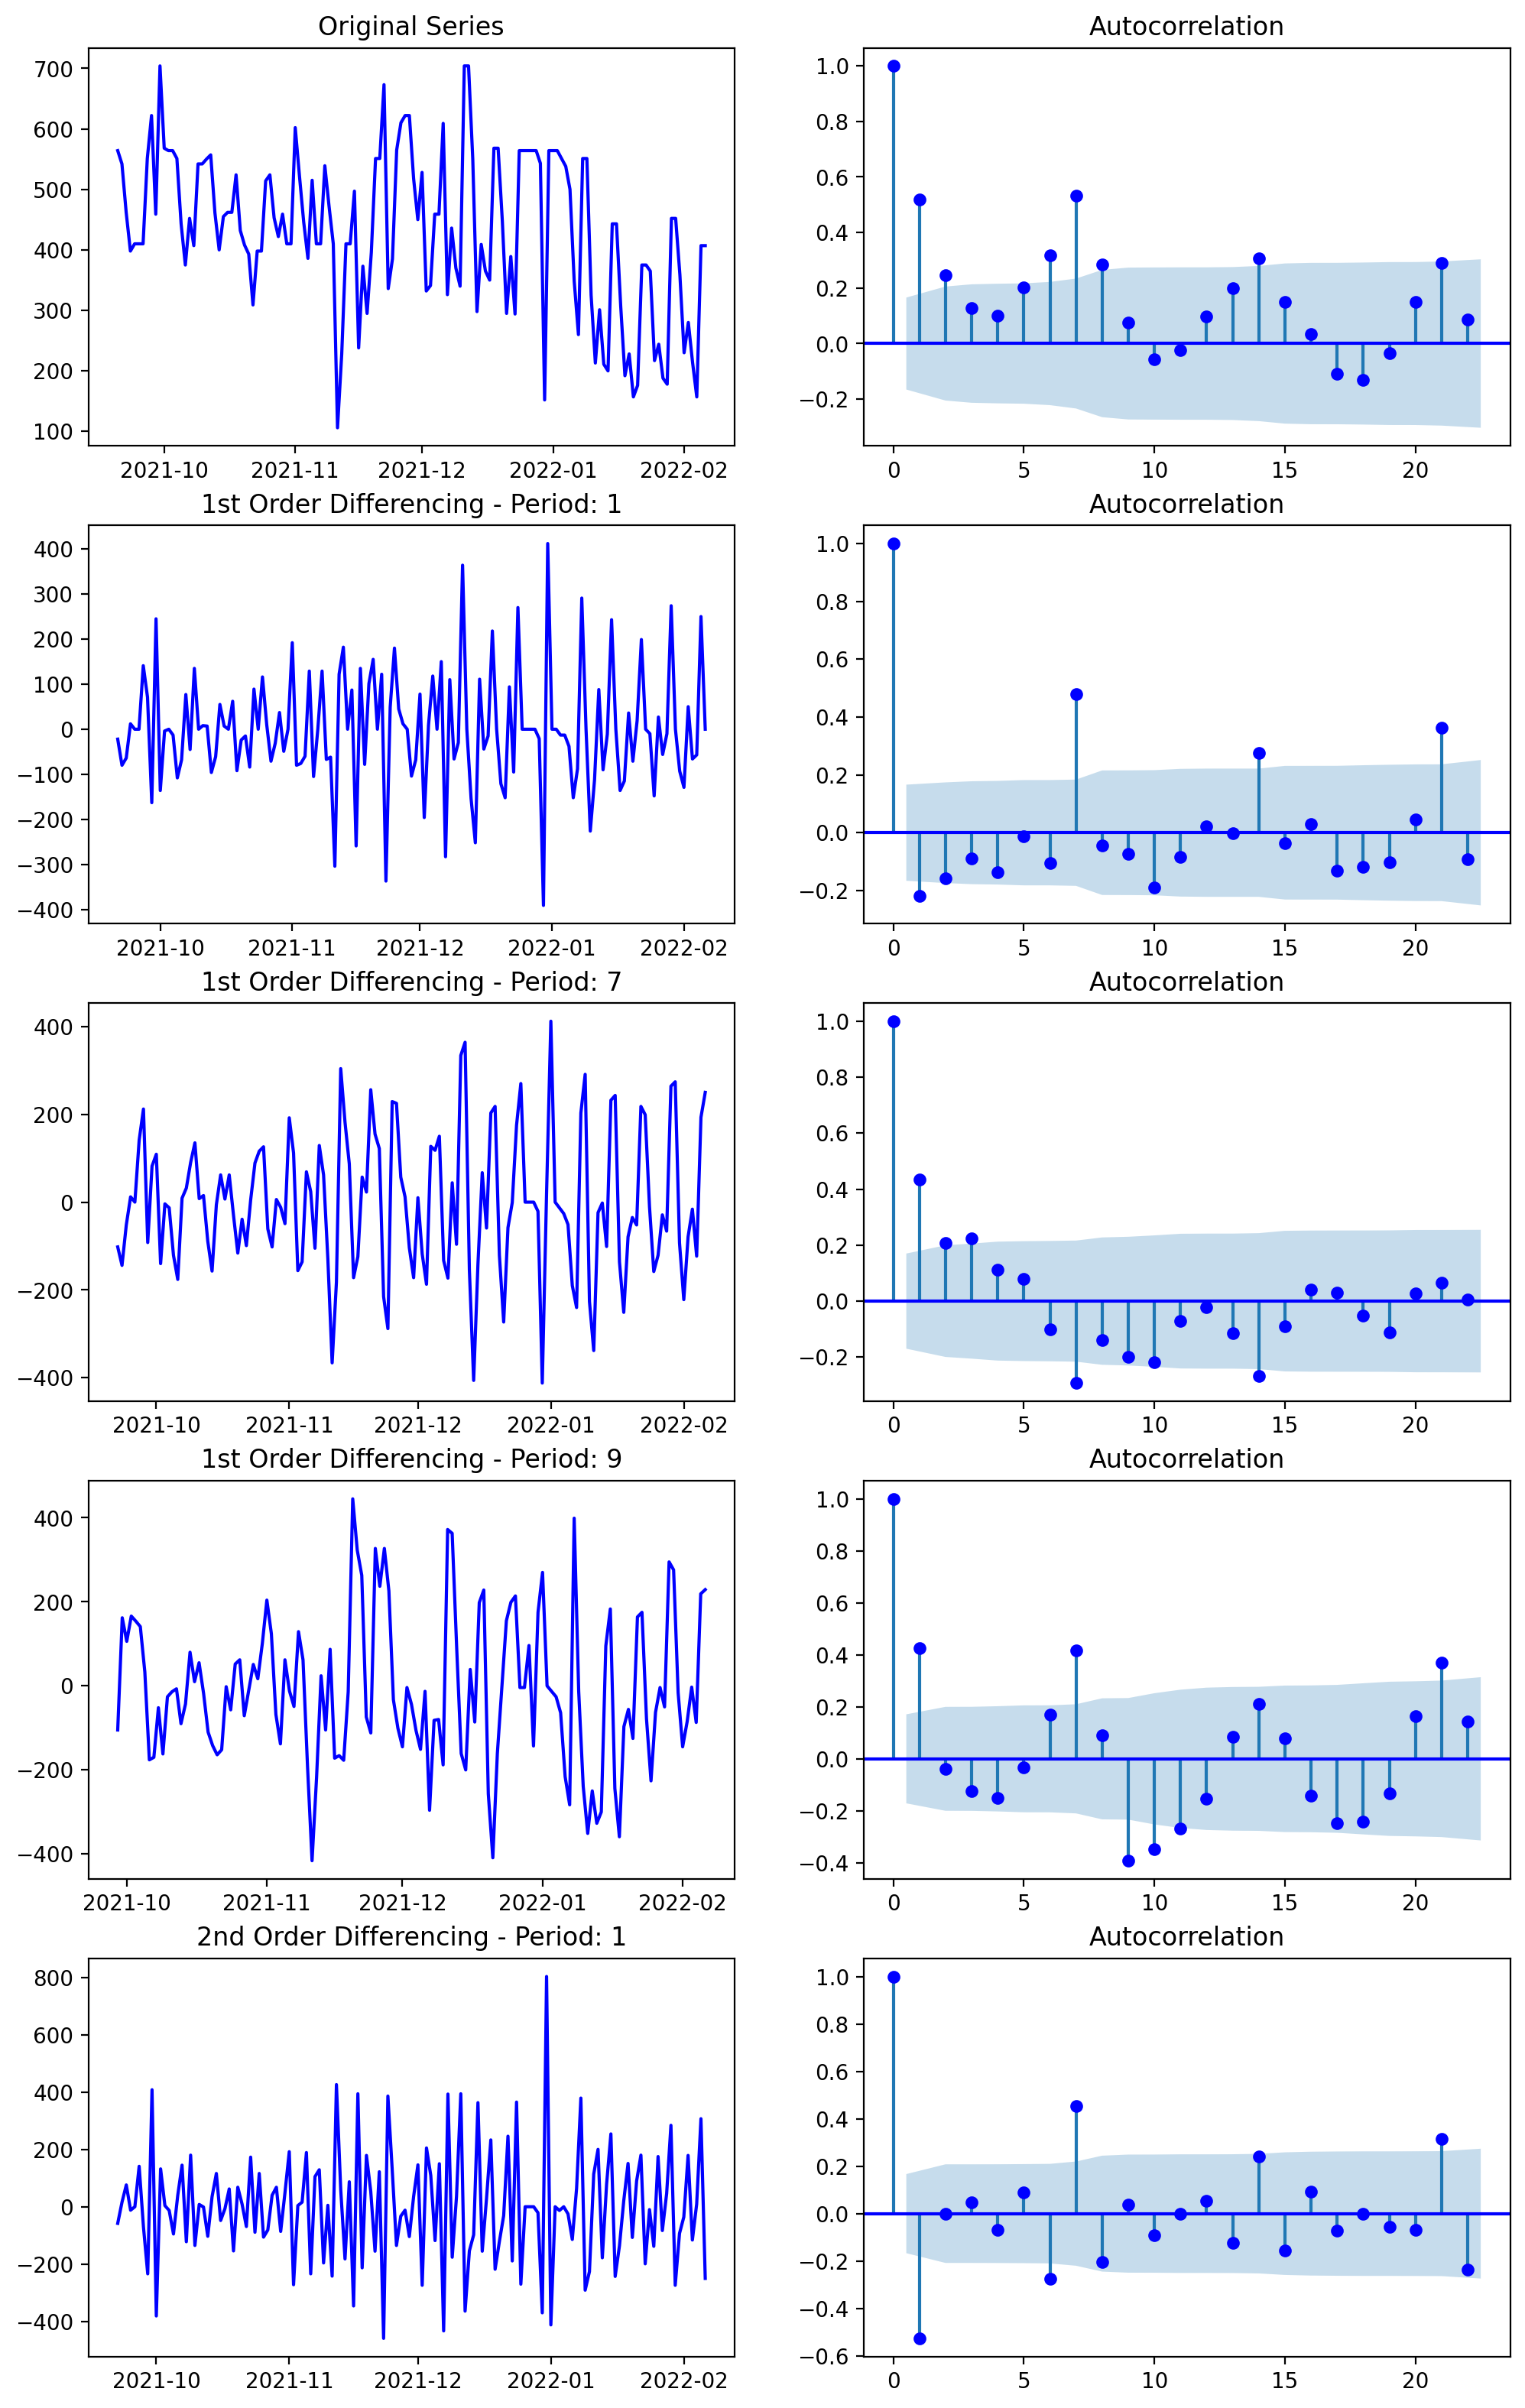

In [19]:
# Criando gráficos

# Criando figura
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':200})
fig, axes = plt.subplots(5, 2, figsize=[12,20])

# Série original
axes[0, 0].plot(dfn['Value'], color='blue')
axes[0, 0].set_title('Original Series')
plot_acf(dfn['Value'], ax = axes[0, 1], color='blue')


# Série após diferenciação

# Primeira diferenciação - 1st order
axes[1, 0].plot(dfn['Value'].diff(periods=1), color='blue')
axes[1, 0].set_title('1st Order Differencing - Period: 1')
plot_acf(dfn['Value'].diff(periods=1).dropna(), ax = axes[1, 1], color='blue')

# Segunda diferenciação - 1st order
axes[2, 0].plot(dfn['Value'].diff(periods=2), color='blue')
axes[2, 0].set_title('1st Order Differencing - Period: 7')
plot_acf(dfn['Value'].diff(periods=7).dropna(), ax = axes[2, 1], color='blue')

# Terceira diferenciação - 1st order
axes[3, 0].plot(dfn['Value'].diff(periods=9), color='blue')
axes[3, 0].set_title('1st Order Differencing - Period: 9')
plot_acf(dfn['Value'].diff(periods=9).dropna(), ax = axes[3, 1], color='blue')

# Primeira diferenciação - 2nd order
axes[4, 0].plot(dfn['Value'].diff().diff(), color='blue')
axes[4, 0].set_title('2nd Order Differencing - Period: 1')
plot_acf(dfn['Value'].diff().diff().dropna(), ax = axes[4, 1], color='blue')

monthyearFmt = mdates.DateFormatter('%Y-%m')
axes[0, 0].xaxis.set_major_formatter(monthyearFmt)
axes[0, 0].xaxis.set_major_locator(mdates.MonthLocator(interval=1))

axes[1, 0].xaxis.set_major_formatter(monthyearFmt)
axes[1, 0].xaxis.set_major_locator(mdates.MonthLocator(interval=1))

axes[2, 0].xaxis.set_major_formatter(monthyearFmt)
axes[2, 0].xaxis.set_major_locator(mdates.MonthLocator(interval=1))

axes[3, 0].xaxis.set_major_formatter(monthyearFmt)
axes[3, 0].xaxis.set_major_locator(mdates.MonthLocator(interval=1))

axes[4, 0].xaxis.set_major_formatter(monthyearFmt)
axes[4, 0].xaxis.set_major_locator(mdates.MonthLocator(interval=1))

plt.show()

Vemos que após a diferenciação de primeira ordem com um período 7 dias, a série apresenta uma estacionaridade fraca. Tentaremos usar a diferenciação de primeira ordem e determinaremos os melhores parâmetros para AR e MA.

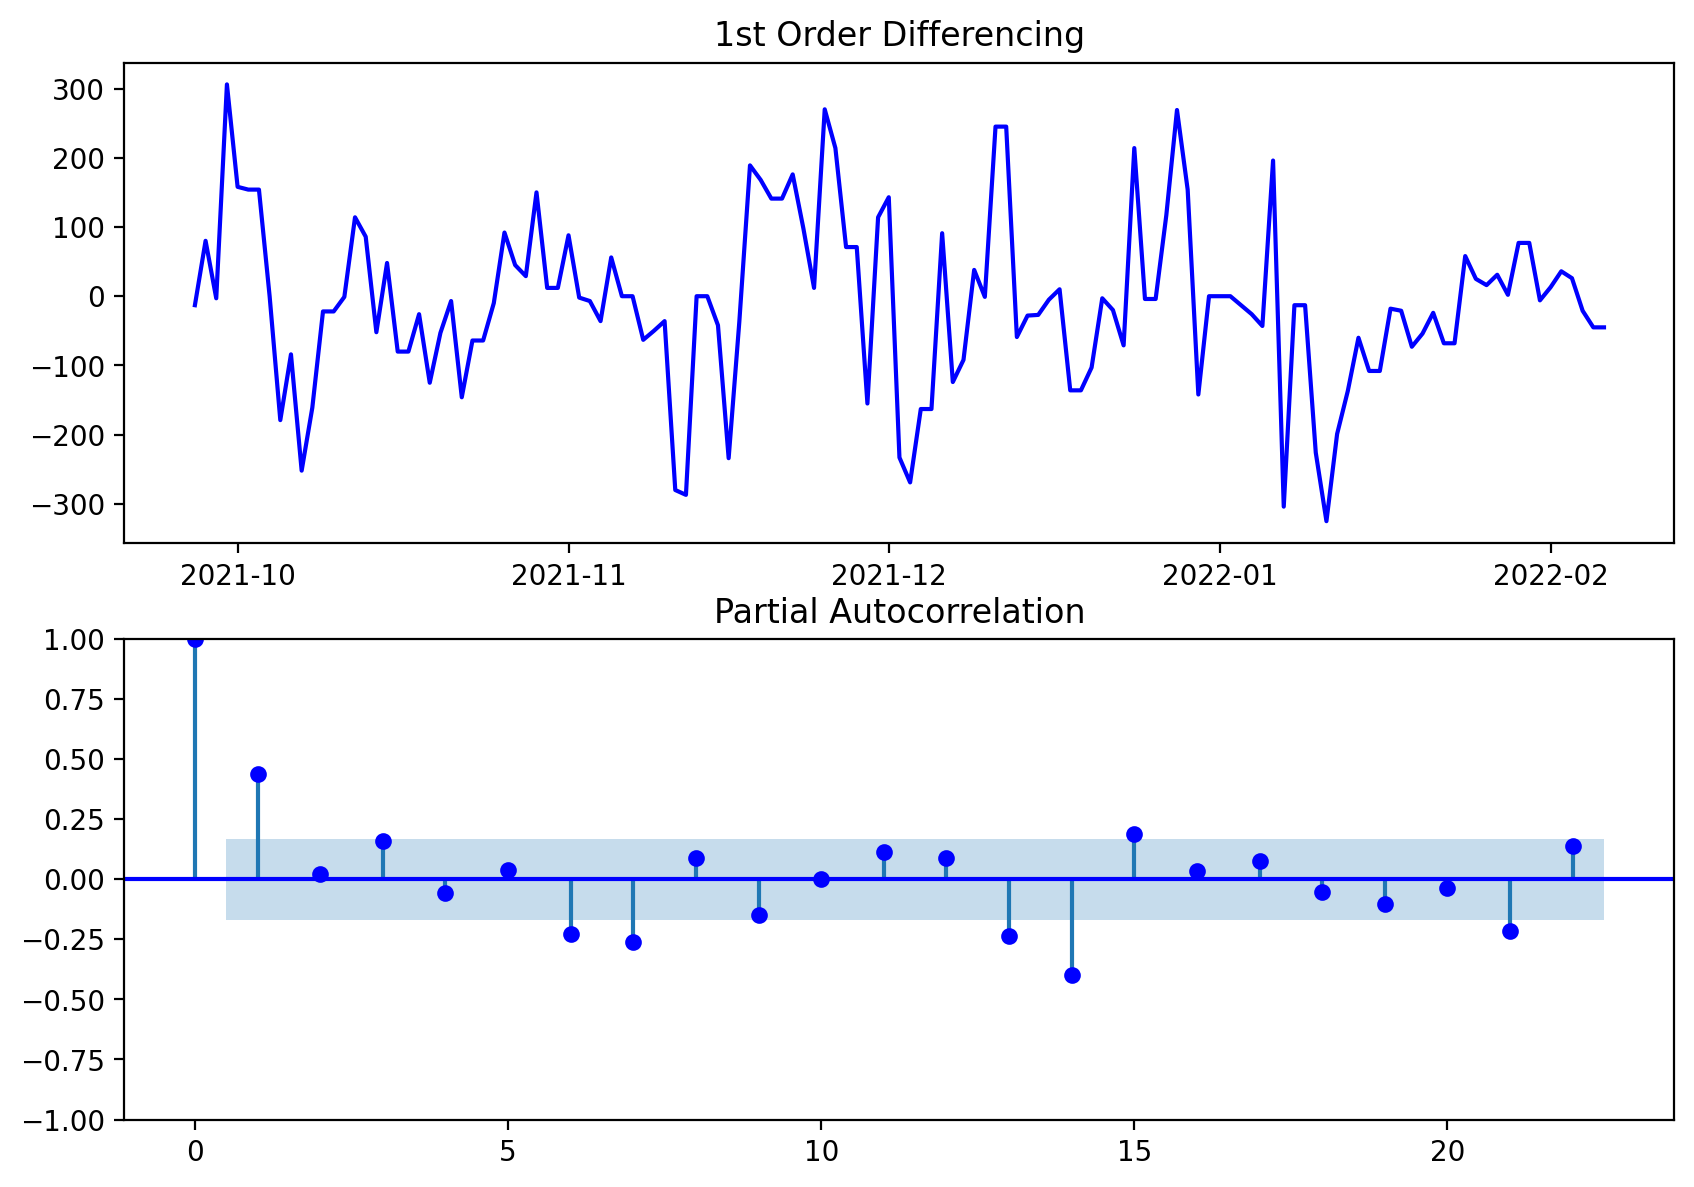

In [20]:
# PACF plot of 1st differenced series
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':200})

fig, axes = plt.subplots(2, 1, figsize=[10,7])
axes[0].plot(dfn['Value'].diff(periods=7), color='blue'); axes[0].set_title('1st Order Differencing')
axes[1].set(ylim=(-1,1))
plot_pacf(dfn['Value'].diff(periods=7).dropna(), ax=axes[1], color='blue')

monthyearFmt = mdates.DateFormatter('%Y-%m')
axes[0].xaxis.set_major_formatter(monthyearFmt)
axes[0].xaxis.set_major_locator(mdates.MonthLocator(interval=1))

plt.show()

Para a diferenciação de primeira ordem, considerando o período igual a 7, vemos que o lag = 1 apresenta um valor maior que o nível de significância 0.05 (região azul), sendo assim, tentaremos corrigir a estacionaridade fraca considerando p = 1.

Considerando o gráfico de autocorrelação para a série diferenciada usando um período igual a 7, vemos que o lag = 1 e 3 apresentam valores acima do nível de significância. Sendo assim, testaremos os modelos para q = 1 e q = 3.

Para isso, iremos separar parte dos dados para o treinamento e outra para validação do modelo. Neste caso, iremos usar as 7 últimas entradas para validação e o restante será usado para teste.

In [21]:
# Separar dataset
ponto_separacao = len(dfn) - 7
dataset, validation = dfn[:ponto_separacao], dfn[ponto_separacao:]
print('Dados para: \n\nTreino: %d\nValidação: %d' % (len(dataset), len(validation)))

Dados para: 

Treino: 133
Validação: 7


In [22]:
# Função para diferenciar a série temporal
def difference(dataset, interval=1):
    diff = []
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return np.array(diff)

In [23]:
X = dataset.values.T[0]
period = 7
differenced = difference(dataset = X, interval = period)

### Modelo ARIMA (p = 1 e q = 1)

In [24]:
# Instanciando o modelo
model = ARIMA(differenced, order=(1,0,1))

# Ajustando o modelo com os dados de teste
model_fit = model.fit(disp=0)

# Imprimindo o resumo do ajuste
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  126
Model:                     ARMA(1, 1)   Log Likelihood                -773.762
Method:                       css-mle   S.D. of innovations            112.302
Date:                Tue, 08 Feb 2022   AIC                           1555.525
Time:                        16:36:48   BIC                           1566.870
Sample:                             0   HQIC                          1560.134
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -7.9766     18.761     -0.425      0.671     -44.747      28.794
ar.L1.y        0.5481      0.233      2.355      0.019       0.092       1.004
ma.L1.y       -0.1462      0.291     -0.503      0.6

## Modelo ARIMA (p = 3 e 1 $\leq$ q $\leq$ 3)

In [25]:
q = np.arange(1, 4, 1)
for item in q:
    print('*' * 78)
    print(' ' * 35 + 'q = %d' %(item))
    print('*' * 78)
    
    # Instanciando o modelo
    model = ARIMA(differenced, order=(3,0,item))
    
    # Ajustando o modelo com os dados de teste
    model_fit = model.fit(disp=0)
    
    # Imprimindo o resumo do ajuste
    print(model_fit.summary(),end='\n\n')

******************************************************************************
                                   q = 1
******************************************************************************
                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  126
Model:                     ARMA(3, 1)   Log Likelihood                -771.865
Method:                       css-mle   S.D. of innovations            110.581
Date:                Tue, 08 Feb 2022   AIC                           1555.731
Time:                        16:36:48   BIC                           1572.748
Sample:                             0   HQIC                          1562.644
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      

Comparando os resultados, vemos que o modelo ARIMA(3, 0, 2) apresenta o melhor resultado, uma vez que os scores AIC e BIC diminuíram. Sendo assim, consideraremos o modelo citado acima para realizar as previsões.

Vale ressaltar que d = 0, pois a a diferenciação foi feita através da função "difference".

### Modelo ARIMA (3, 0, 2)

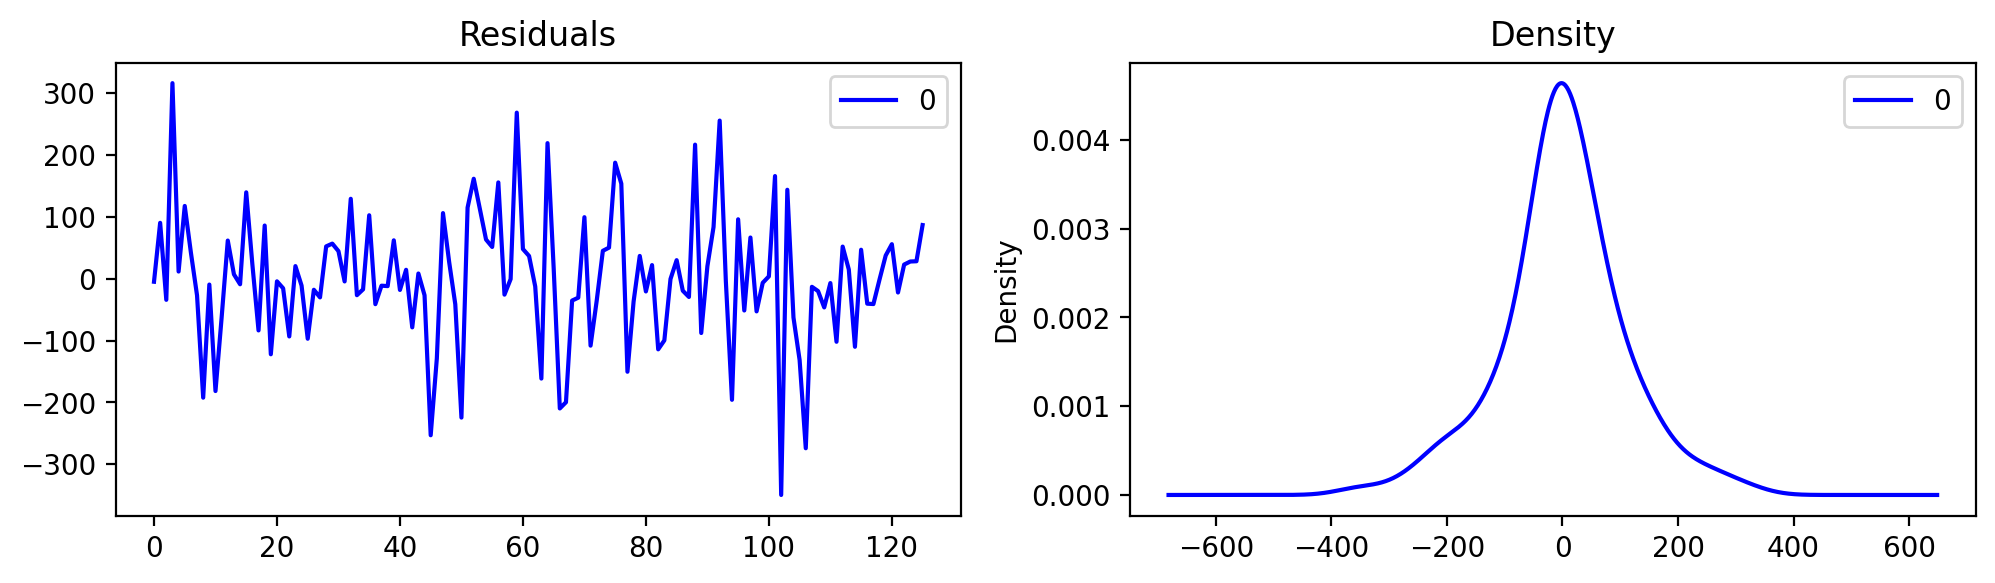

In [26]:
# Instanciando o modelo
model = ARIMA(differenced, order=(3,0,2))

# Ajustando o modelo com os dados de teste
model_fit = model.fit(disp=0)

# Criando gráficos dos resíduos
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2, figsize=[12,3])
residuals.plot(title="Residuals", ax=ax[0], color='blue')
residuals.plot(kind='kde', title='Density', ax=ax[1], color='blue')
plt.show()

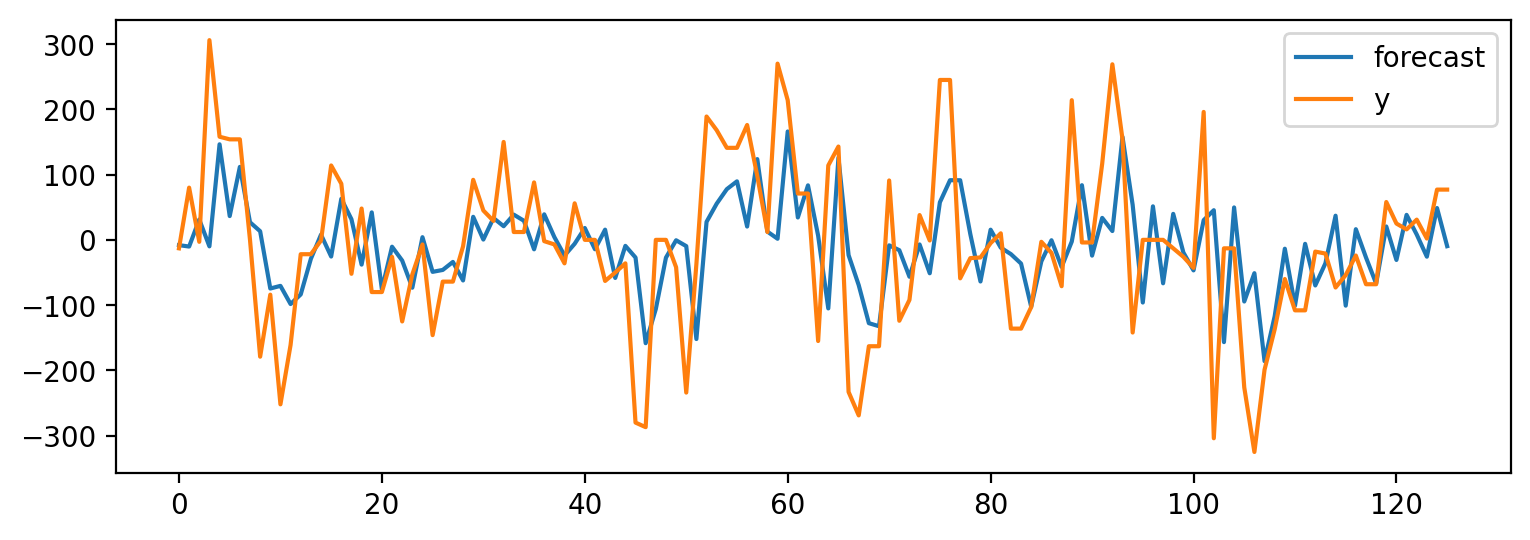

In [27]:
# Actual vs Fitted (1st order differencing)
model_fit.plot_predict(dynamic=False)
plt.show()

De maneira geral, vemos que o modelo, a linha azul (forecast), representa bem a tendência da série temporal, linha laranja (y). Além disso, a distribuição dos resíduos se dá ao redor de zero com uma variância uniforme. Antes de avaliar o valor predito, precisamos retorná-lo para o valor real. Faremos isso usando a função "inverse_difference".

In [29]:
#Função para inverter o valor previsto para o valor real.
def inverse_difference(history, yhat, interval=1):
    
    lista_yhat = []
    yhat_ = []
    
    for item in range(0, len(history)):
        if (item < interval):
            lista_yhat.append(history[item])
            
    for item in range(0, len(yhat)):
        lista_yhat.append(item)
    
    i = 0
    for item1, item2 in zip(lista_yhat, history):
        if (i > 7):
            yhat_.append(item1 + item2)
        else:
            yhat_.append(item1)
            i += 1
                             
    return yhat_

historico = [x for x in X]
y_pred = inverse_difference(history = historico, yhat = model_fit.fittedvalues, interval = period)

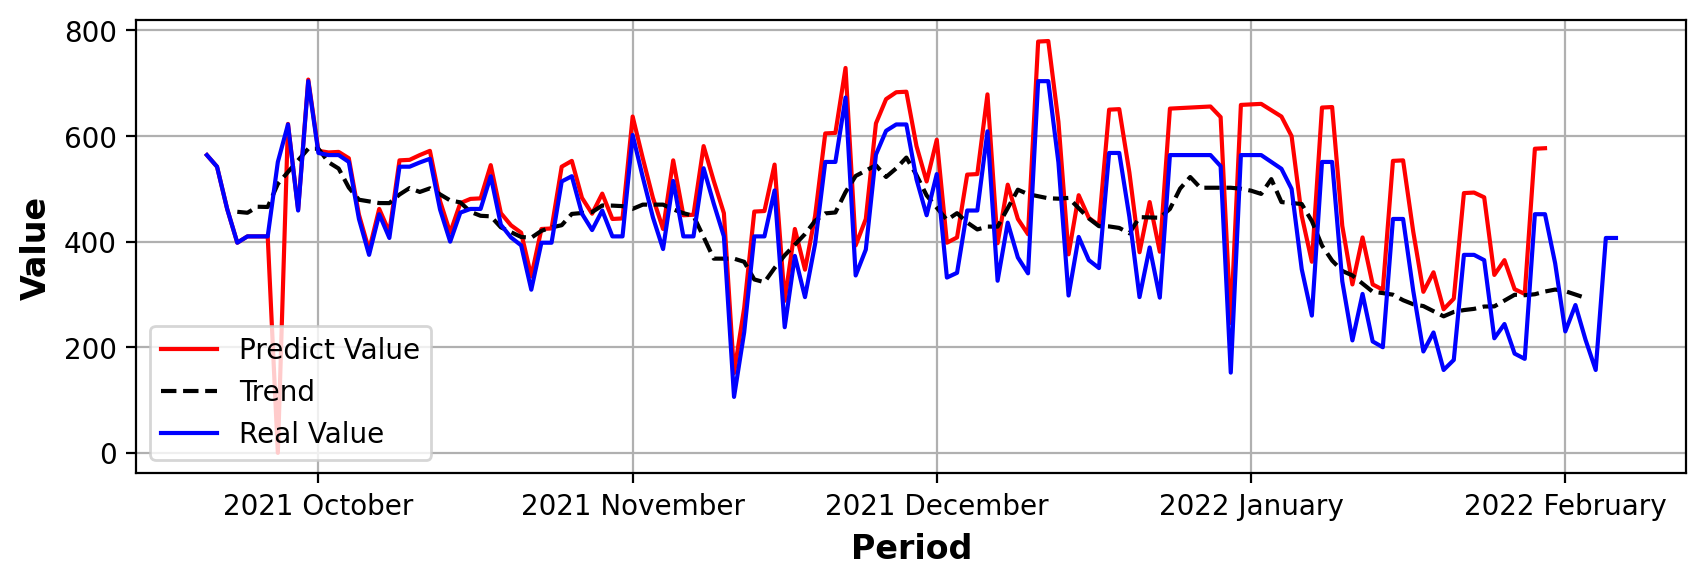

In [30]:
# Gráfico mostrando o valor predito, o valor observado e a tendência.
# Removendo valores nulos da tendência
res.trend.dropna(inplace=True)
res.trend.isnull().sum()

# Criando gráfico
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':200})
fig, ax = plt.subplots(figsize=[10,3])

# Valor predito
plt.plot(dataset.index, y_pred, color='red', label='Predict Value')

# Tendência
plt.plot(res.trend.index, res.trend.values, ls='--', color='black', label='Trend')

# Valor observado
plt.plot(dfn.index, dfn.Value, color='blue', label='Real Value')

# Legenda
plt.legend(loc='best')

# Formatação do eixo x
monthyearFmt = mdates.DateFormatter('%Y %B')
ax.xaxis.set_major_formatter(monthyearFmt)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))

# Título dos eixos x e y
plt.xlabel('Period', fontsize = 12, fontweight='bold')
plt.ylabel('Value', fontsize = 12, fontweight='bold')

# Linhas de grade
plt.grid()

plt.show()

No gráfico acima vemos o ajuste do modelo já convertido aos valores reais (linha sólida vermelha), os valores reais (linha sólida) e a tendência da série temporal (linha preta tracejada).

### Usando o modelo para fazer a previsão 7 dias a frente

In [31]:
# Inverter valores para comparar com dados de validação
def inverse_diff(history, yhat, interval=1):
    return yhat + history[-interval]

# Previsão multi-step
start_index = len(differenced)
end_index = start_index + 6
forecast = model_fit.predict(start=start_index, end=end_index)

historico_pred = y_pred.copy()
y_forecast = []

# Inverte a diferença dos valores
day = 1
for yhat in forecast:
    inverted = inverse_diff(historico, yhat, period)
    print('Day %d: %f' % (day, inverted))
    historico_pred.append(inverted)
    y_forecast.append(inverted)
    day += 1

Day 1: 417.159682
Day 2: 397.641854
Day 3: 337.737599
Day 4: 393.947403
Day 5: 341.747605
Day 6: 354.479038
Day 7: 380.231823


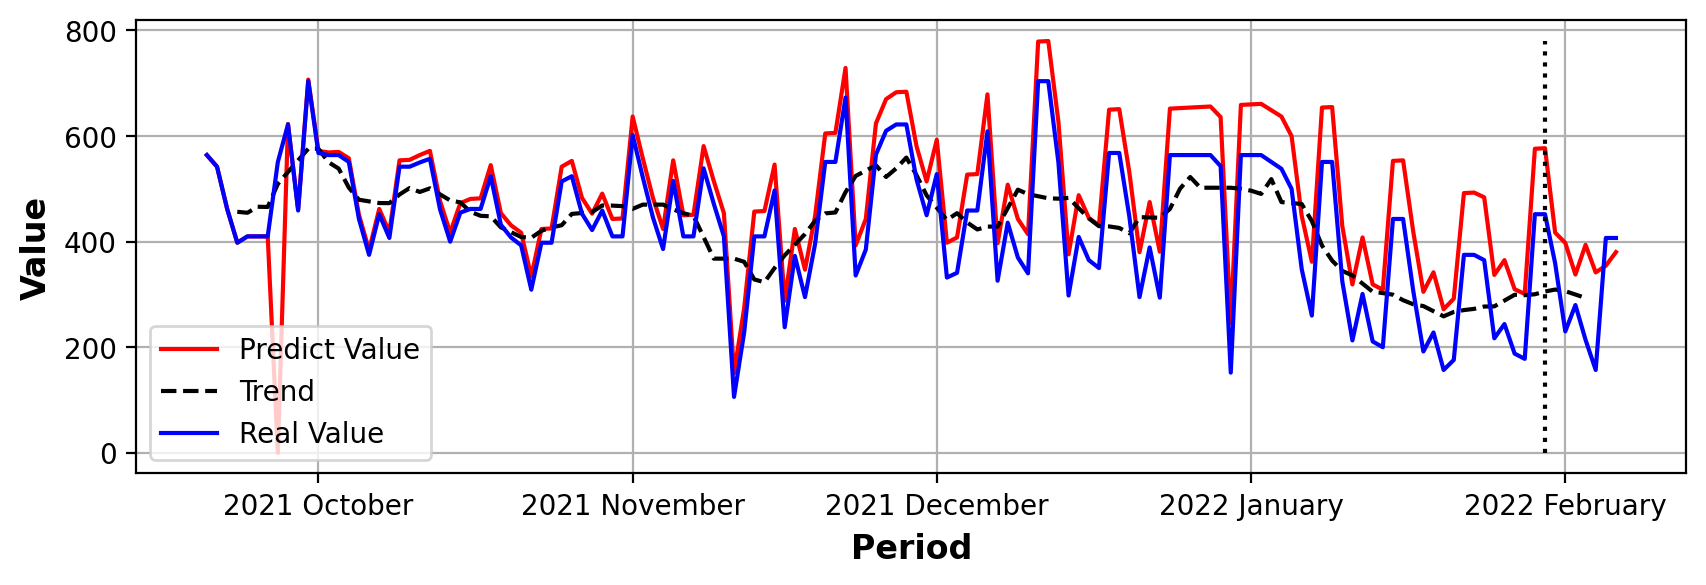

In [32]:
# Gráfico mostrando o valor predito, o valor observado e a tendência.
# Removendo valores nulos da tendência
res.trend.dropna(inplace=True)
res.trend.isnull().sum()

# Criando gráfico
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':200})
fig, ax = plt.subplots(figsize=[10,3])

# Valor predito
plt.plot(dfn.index, historico_pred, color='red', label='Predict Value')

# Tendência
plt.plot(res.trend.index, res.trend.values, ls='--', color='black', label='Trend')

# Valor observado
plt.plot(dfn.index, dfn.Value, color='blue', label='Real Value')

# Validação
x = [dataset.index[-1], dataset.index[-1]]
y = [0, np.max(y_pred)]
plt.plot(x, y, ls=':', color='black')

# Legenda
plt.legend(loc='best')

# Formatação do eixo x
monthyearFmt = mdates.DateFormatter('%Y %B')
ax.xaxis.set_major_formatter(monthyearFmt)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))

# Título dos eixos x e y
plt.xlabel('Period', fontsize = 12, fontweight='bold')
plt.ylabel('Value', fontsize = 12, fontweight='bold')

# Linhas de grade
plt.grid()

plt.show()

O gráfico acima mostra o valor predito para os 7 dias dos dados de validação, após a linha vertical pontilhada em preto. Dessa forma, vemos que o modelo prevê bem a tendência da série temporal. Abaixo, vemos o valor observado em função do valor predito. O ideal é todos os pontos estivessem sobre a linha preta tracejada ou acima. Dessa forma, vemos que a tendência do modelo é de realizar previsões com valores superiores ao valor real.

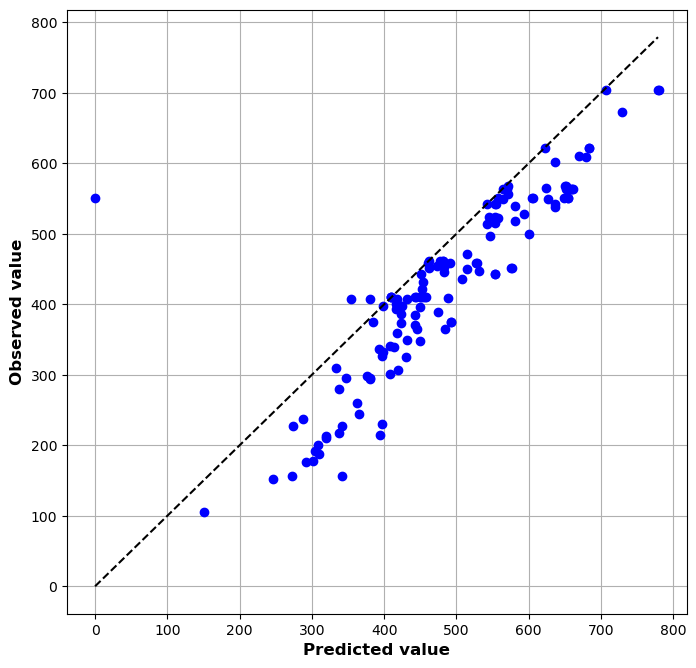

In [33]:
# Gráfico entre valor predito x valor observado
# Criando gráfico
plt.rcParams.update({'figure.dpi':100})
fig, ax = plt.subplots(figsize=[8,8])

# Valor predito
plt.plot(historico_pred, dfn.Value, color='blue', ls='', marker='o')

# Valor observado
x = y = np.arange(0,np.max(historico_pred))
plt.plot(x, y, color='black', ls='--')


# Título dos eixos x e y
plt.xlabel('Predicted value', fontsize = 12, fontweight='bold')
plt.ylabel('Observed value', fontsize = 12, fontweight='bold')

# Linhas de grade
plt.grid()

plt.show()

Abaixo vemos a tabela com a comparação entre o valor predito e o valor observado dos dados de validação.

In [42]:
lista_datas = []
lista_valor_obs = []
lista_valor_pred = []

for item1, item2, item3 in zip(validation.index.values, validation.values, y_forecast):
    lista_datas.append(pd.to_datetime(item1))
    lista_valor_obs.append(item2)
    lista_valor_pred.append(item3)
    
df_comp = pd.DataFrame(np.c_[lista_datas, lista_valor_obs, lista_valor_pred],
                      columns = ['Date', 'Observed Value', 'Predicted Value'])
df_comp['Diff.[%]'] = (1 - df_comp['Observed Value'] / df_comp['Predicted Value']) * 100
df_comp

,Date,Observed Value,Predicted Value,Diff.[%]
0,2022-01-31,359.0,303.257822,-18.381118
1,2022-02-01,230.0,371.799441,38.138691
2,2022-02-02,280.0,336.416685,16.769883
3,2022-02-03,214.0,348.085387,38.520832
4,2022-02-04,157.0,376.105516,58.256395
5,2022-02-05,407.0,327.644846,-24.219869
6,2022-02-06,407.0,376.463911,-8.111292


In [35]:
print('A diferença média, em porcentagem é: %s %%' %(str(round(df_comp['Diff.[%]'].mean(),2))))

A diferença média, em porcentagem é: 21.58 %


### Previsão para os próximo 7 dias

Agora, conhecendo os melhores parâmetros para ajuste do modelo, faremos a previsão para os próximos 7 dias da semana.

In [44]:
period = 7
differenced = difference(dataset = dfn.Value, interval = period)

# Instanciando o modelo
model = ARIMA(differenced, order=(3,0,2))

# Ajustando o modelo com os dados de teste
model_fit = model.fit(disp=0)

# Previsão multi-step
start_index = len(differenced)
end_index = start_index + 6
forecast = model_fit.predict(start=start_index, end=end_index)

historico_pred = y_pred.copy()
y_forecast = []

# Inverte a diferença dos valores
day = df_comp['Date'][6]
for yhat in forecast:
    inverted = inverse_diff(dfn.values, yhat, period)
    print('%s: %f' % (str(day.strftime('%Y-%m-%d')), inverted))
    day += pd.DateOffset(days=1)

2022-02-06: 297.257822
2022-02-07: 365.799441
2022-02-08: 330.416685
2022-02-09: 342.085387
2022-02-10: 370.105516
2022-02-11: 321.644846
2022-02-12: 370.463911
